<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**


---

# Predicting Health Insurance costs

When acquiring Health Insurance, it is common that the we pay a fixed and low amount of money, in return to being covered by the insurance over a high amount of charges during a moment of healthcare need or emergency. Given this fact, is important for insurance companies to predict the cost of customers in case such an event arises, so that their business is still feasible. This is a difficult issue, because it is hard to predict when and how someone will become ill. However, certain aspects of people's behaviour, habits and medical history might be able to tell us how much these patients will cost for the insurance company.

<p align=center>
<img src="img/health_insurance.png" width="30%"><br>
<i><sup>Image credits: pch.vector (<a href="https://br.freepik.com/vetores-gratis/pai-apertando-as-maos-com-agente-de-seguros_6974887.htm">www.freepik.com</a>)</sup></i>
</p>

In this notebook we will be looking at a Health Insurance Cost dataset, using regression machine learning models in [PyCaret](https://pycaret.org/). PyCaret is a popular, low-code library, that provides an automated way to create data analysis workflows using Machine Learning. It aims to reduce time used for coding the models, while leaving more time for the analyses themselves.

# The Data

The data for this project was obtained on [Kaggle](https://www.kaggle.com/annetxu/health-insurance-cost-prediction). There is not much information about it on the page, but it is a simple dataset (with 7 columns, only) which features characteristics of the individuals and their insurance charges over the period analysed (unknown). For ease of access I have downloaded the dataset and included it in the `data` folder for this project.


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import tools

# Importing pycaret tools
from pycaret.regression import setup, compare_models, models, create_model, predict_model
from pycaret.regression import tune_model, plot_model, interpret_model, evaluate_model, finalize_model
from pycaret.regression import save_model, load_model

# Getting the data
df = pd.read_csv("data/insurance.csv")

# Life, the Universe, and Everything
np.random.seed(42)

# Defining plot parameters
# plt.style.use('dark_background')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.stretch'] = 'normal'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.variant'] = 'normal'

# Checking first entries of the dataset
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
# Dataset size
df.shape

(1338, 7)

## Data variables

As mentioned above, the dataset comes with 1338 observations and 7 columns only, which are:

* `age` = The age of the individual insurance client.
* `sex` = The biological sex.
* `bmi` = Body Mass Index, a health measure based on weight divided by the squared height.
* `children` = The number of children the individual has.
* `smoker` = If they smoke or not.
* `region` = The region where they live (related to the dataset origin, other information unknown).
* `charges` = The incurred charges originanting from the specific individual. *This is our target variable*.

First, we will observe our variables and make sure that their types match the expected.

In [3]:
# Checking types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# Describing our dataset
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Now, let us use SweetViz for a more compreensive view of our variables.

In [ ]:
sweetviz = sv.analyze(df)
sweetviz.show_html('reg.html')

(Click [here](https://htmlpreview.github.io/?https://github.com/cfantecelle/data_science_portfolio/blob/63680c0f93d8a1fadaca7be2c21e7b8b283ee368/project_automl/reg.html) to see the HTML report from GitHub.)

We can see that our `age` variable only ranges between 18 and 64. If it were there were older people in the dataset, it would be a good idea to create and additional column categorizing the ages, since we know that older people will often need more health care than younger people. Also, the age of the individuals has a somewhat uniform distribution, with the exception of an increase around the lower end of the age range.

The `sex` variable, which might as well influence our predictions is well balanced. The `region` variable is also well balanced.

The `children` variable is more skewed towards the lower end of the distribution, but this is a potential factor that might be associated to our outcome, due to children being able to get ill easier through, for example, school contact.

Our target variable, `charges`, presents with some obvious outliers, but these are of extreme interest in the case of predicting costs in a health insurance scenario.

The `smoker` variable is also unbalanced, with ~20% of smokers in the dataset. This also represents a health risk factor, and the variable will be left as is.

Another possible risk factor for health conditions is **adiposity**. Weight and height alone (the measurements used to calculate BMI - Body Mass Index) are not good enough factors to evaluate someone's adiposity levels and we should be careful not to fat shame other people in the name of their health condition (viewers can read more on it [here](https://www.goodhousekeeping.com/health/a35422452/fat-phobia/)). However, historically the BMI and the categories defined by it have been associate to negative health conditions. Thus, here we will classify the data according to the [BMI standards](https://www.who.int/europe/news-room/fact-sheets/item/a-healthy-lifestyle---who-recommendations) and we will compare how this measurement influences our predictions.

In [6]:
# Copying dataset
df_bmi = df.copy()

# Removing column from other df
df = df.drop('bmi', axis = 1)

Let's discretise our BMI variable:

In [7]:
# Adding new column with BMI category
conditions = [
    (df_bmi['bmi'] < 18.5),
    (df_bmi['bmi'] >= 18.5) & (df_bmi['bmi'] < 25),
    (df_bmi['bmi'] >= 25) & (df_bmi['bmi'] < 30),
    (df_bmi['bmi'] >= 30) & (df_bmi['bmi'] < 35),
    (df_bmi['bmi'] >= 35) & (df_bmi['bmi'] < 40),
    (df_bmi['bmi'] >= 40)]
classes = ['Underweight', 'Regular', 'Overweight', 'Obesity 1', 'Obesity 2', 'Obsesity 3']
df_bmi['bmi_class'] = np.select(conditions, classes)

df_bmi

,age,sex,bmi,children,smoker,region,charges,bmi_class
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Obesity 1
2,28,male,33.000,3,no,southeast,4449.46200,Obesity 1
3,33,male,22.705,0,no,northwest,21984.47061,Regular
4,32,male,28.880,0,no,northwest,3866.85520,Overweight
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,Obesity 1
1334,18,female,31.920,0,no,northeast,2205.98080,Obesity 1
1335,18,female,36.850,0,no,southeast,1629.83350,Obesity 2
1336,21,female,25.800,0,no,southwest,2007.94500,Overweight


Now we separate our train and test, in both datasets:

In [8]:
# Creating test dataset
test = df.sample(frac=0.1)

# Creating train data by dropping test data
train = df.drop(test.index)

# Resetting indexes
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [9]:
# Checking sizes
print(train.shape)
print(test.shape)

(1204, 6)
(134, 6)


In [10]:
# Creating test dataset with bmi
test_bmi = df_bmi.sample(frac=0.1)

# Creating train data by dropping test data
train_bmi = df_bmi.drop(test.index)

# Resetting indexes
train_bmi.reset_index(inplace=True, drop=True)
test_bmi.reset_index(inplace=True, drop=True)

In [11]:
# Checking sizes
print(train_bmi.shape)
print(test_bmi.shape)

(1204, 8)
(134, 8)


Let's start with PyCaret.

# Regression with PyCaret

First, we pass our data to PyCaret.

## Creating regressor

In [12]:
# Creating regressor using PyCaret
reg = setup(data=train, target='charges')

,Description,Value
0,session_id,8321
1,Target,charges
2,Original Data,"(1204, 6)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(842, 13)"


From this initial report, we can see that our dataset has no missing values. Thus, we can proceed to create our pipeline. We will do so using both BMI information or not.

## PyCaret pipeline

### No BMI information

In [13]:
# Creating pipeline
reg = setup(data=train,
            target='charges',
            normalize=True,
            normalize_method='zscore',
            experiment_name='HealthInsuranceCosts',
            session_id=42,
            )

,Description,Value
0,session_id,42
1,Target,charges
2,Original Data,"(1204, 6)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(842, 13)"


Now that our setup has been initiated, let us compare how each regressor model behaves with our dataset.

In [14]:
# Checking regression models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,4242.7303,43060682.2000,6498.8676,0.7034,0.4236,0.3170,0.5220
llar,Lasso Least Angle Regression,4247.4327,43129095.2799,6504.4620,0.7030,0.4266,0.3217,0.0040
ridge,Ridge Regression,4266.8887,43199940.8000,6511.0019,0.7025,0.4275,0.3230,0.0040
br,Bayesian Ridge,4262.1193,43205265.1283,6511.3029,0.7025,0.4273,0.3218,0.0040
lasso,Lasso Regression,4243.4343,43199145.4000,6510.2682,0.7024,0.4264,0.3176,0.2010
lar,Least Angle Regression,4249.9853,43500994.7654,6536.4314,0.7002,0.4320,0.3159,0.0030
gbr,Gradient Boosting Regressor,4342.2661,47254799.3089,6798.5949,0.6766,0.4469,0.3494,0.0090
lightgbm,Light Gradient Boosting Machine,4529.8727,50302706.1469,7013.7790,0.6542,0.5028,0.3803,0.0150
huber,Huber Regressor,3610.0381,49729257.1600,6965.7995,0.6517,0.4474,0.2196,0.0060
ada,AdaBoost Regressor,5869.7095,52186237.8850,7191.4163,0.6397,0.6487,0.7936,0.0060


From this we can see that our best model was the **Linear Regression**. However, these values are not ideal, especially with a 0.6837 R squared. Let's see how the model with the BMI information performs.

### With BMI information

In [15]:
# Creating pipeline
reg = setup(data=train_bmi,
            target='charges',
            normalize=True,
            normalize_method='zscore',
            experiment_name='HealthInsuranceCosts',
            session_id=42,
            )

,Description,Value
0,session_id,42
1,Target,charges
2,Original Data,"(1204, 8)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(842, 20)"


In [16]:
# Checking regression models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2540.9395,20828295.2969,4529.8505,0.8378,0.4203,0.2953,0.0120
catboost,CatBoost Regressor,2689.8290,21895059.2931,4656.2043,0.8289,0.4316,0.3044,0.2360
rf,Random Forest Regressor,2647.8099,21934354.2166,4648.0716,0.8269,0.4348,0.3054,0.0480
lightgbm,Light Gradient Boosting Machine,2834.0166,22125739.2020,4666.9655,0.8263,0.4915,0.3431,0.0100
et,Extra Trees Regressor,2650.5254,24457871.2493,4921.3975,0.8124,0.4570,0.3053,0.0440
ada,AdaBoost Regressor,4012.8640,26640907.4593,5142.2051,0.7933,0.6011,0.6620,0.0060
ridge,Ridge Regression,4235.1212,35088450.2000,5892.6508,0.7304,0.5896,0.4522,0.0030
br,Bayesian Ridge,4235.1046,35094328.3153,5893.1054,0.7304,0.5907,0.4522,0.0030
lasso,Lasso Regression,4228.7395,35121967.8000,5894.7053,0.7300,0.5782,0.4516,0.0030
lr,Linear Regression,4229.5004,35122779.2000,5894.6440,0.7300,0.5823,0.4520,0.0030


From the comparisons, the Gradient Boosting Regressor, with an R<sup>2</sup> on the dataset with the BMI information achieved the best metrics in nearly all categories, indicating that this variable still provides us with some prediction power. Let's see how the parameters were set in this model:

In [17]:
# Printing parameters for the best model
print(best)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


With our best model identified, we now must effectively build the model to train our data (this is step is not done during `compare_models()`). For comparison purposes, we will also use the second and third best algorithms identified. These are the **CatBoost** and **Random Forest** Regressors.

## The Gradient Boosting Regressor

The Gradient Boosting Regressor, or simply GBR, is a powerful machine learning model used for predictions. It is based on the construction of weak learners, which are improved by adding them together in an ensembl of predictors that minimizes the loss function<sup><a href="https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/">1</a>,<a href="https://en.wikipedia.org/wiki/Gradient_boosting">2</a></sup>.

It basically has three components<sup><a href="https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/">1</a></sup>:

1. A loss function;
2. Weak learners;
3. The additive model in which the weak learners are added to minimize the loss function.

In this model, the weak learners are added one by one, while existing ones remain unchanged. This is done through a [gradient descent](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html) procedure (iterative method to minimize some function).

### Creating our model

In [18]:
# Creating first model
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2435.4026,14976088.8576,3869.8952,0.9058,0.4031,0.3505
1,2128.3866,13823314.6062,3717.9718,0.8853,0.3312,0.2427
2,2475.1636,18130885.7056,4258.0378,0.8846,0.3876,0.2539
3,3192.2110,33396524.8077,5778.9726,0.7891,0.4922,0.3439
4,2299.0312,19360848.3534,4400.0964,0.8650,0.4135,0.2858
5,2591.0578,23610737.0990,4859.0881,0.8467,0.4642,0.2472
6,2551.0425,20766751.9837,4557.0552,0.8816,0.4596,0.3881
7,2321.4534,18030673.7127,4246.2541,0.8288,0.3393,0.2445
8,2842.7809,23185671.1414,4815.1502,0.8017,0.5349,0.3246


This shows the result we had previously, as the model has been instantiated using the same hyperparameters.

### Tuning the GBR model

In [19]:
# Creating tuned model
tuned_gbr = tune_model(gbr, optimize='R2', choose_better=True, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2664.8646,17082427.0997,4133.0893,0.8925,0.4218,0.3703
1,2183.0544,13918177.4117,3730.7074,0.8845,0.3254,0.2434
2,2588.0702,18940724.9532,4352.0943,0.8794,0.4115,0.2722
3,3332.5578,34648890.8706,5886.3308,0.7812,0.5146,0.3459
4,2318.1813,19370941.9809,4401.2432,0.8649,0.3944,0.2591
5,2779.4912,23385951.5142,4835.9023,0.8481,0.4753,0.2637
6,2238.7633,15171234.7586,3895.0269,0.9135,0.3920,0.3094
7,2363.4572,18099290.0279,4254.3260,0.8282,0.3362,0.2458
8,2946.0357,24085825.3742,4907.7312,0.7940,0.5327,0.3027


## Trying CatBoost and Random Forest Regressors

### CatBoost Regressor

In [20]:
## CatBoost

# Creating model
cat = create_model('catboost')

# Tuning model
tuned_cat = tune_model(cat, optimize='R2', choose_better=True, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2443.9640,15696416.9063,3961.8704,0.9013,0.3867,0.3279
1,2237.3013,13549022.8869,3680.8997,0.8875,0.3442,0.2665
2,2510.8363,18440527.3904,4294.2435,0.8826,0.4056,0.2732
3,3047.0076,31437828.7144,5606.9447,0.8015,0.4332,0.2865
4,2360.3582,19132065.2334,4374.0216,0.8666,0.4287,0.2969
5,2724.6515,24186612.5737,4917.9887,0.8429,0.4585,0.2741
6,2339.3748,15167381.4904,3894.5323,0.9135,0.4130,0.3357
7,2259.2797,17134136.0270,4139.3400,0.8373,0.3269,0.2337
8,2714.4474,21468771.6155,4633.4406,0.8164,0.4732,0.2865


### Random Forest Regressor

In [21]:
## Random Forest

# Creating model
rf = create_model('rf')

# Tuning model
tuned_rf = tune_model(rf, optimize='R2', choose_better=True, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1555.8506,13774551.7555,3711.4083,0.9133,0.2877,0.1434
1,1349.0487,12211031.9460,3494.4287,0.8986,0.2752,0.1194
2,2105.5507,19861777.6753,4456.6554,0.8735,0.3867,0.1582
3,2552.4450,33307129.9508,5771.2330,0.7897,0.4397,0.1704
4,1704.5579,17466839.7810,4179.3348,0.8782,0.3433,0.1554
5,2230.0223,24138214.9009,4913.0657,0.8432,0.4203,0.1648
6,1489.9620,14726963.2915,3837.5726,0.9160,0.3343,0.1271
7,1708.0492,16387783.8855,4048.1828,0.8444,0.3018,0.1417
8,2176.9539,23090624.2233,4805.2705,0.8025,0.5259,0.1683


From these results we can see that the **CatBoost** regressor actually *outperforms* after tunning the hyperparameters. The main difference between CatBoost and other gradient boosted regressors is that CatBoost produces symmetrical trees, which helps the model by reducing the time to perform predictions<sup><a href="https://developer.nvidia.com/blog/catboost-fast-gradient-boosting-decision-trees/">3</a></sup>. From this point forward, since this was the best model, we will use **CatBoost** on our previously split test data.

### Evaluating our best model

To evaluate our best model, we will look at some plots.

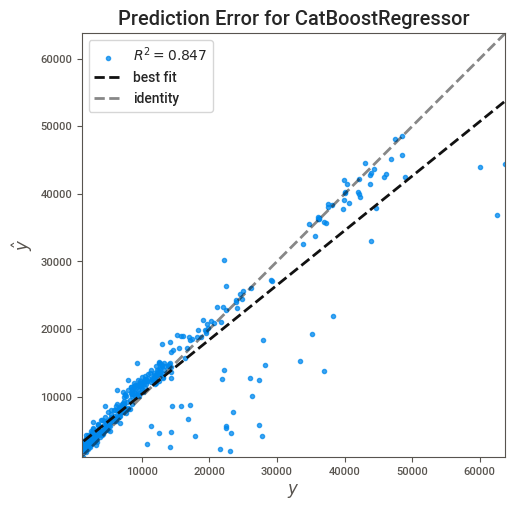

In [22]:
## Evaluating model

# Plotting prediction error
plot_model(tuned_cat, plot = 'error')

From this, we can see that our best fit is closely related to the identity line, as demonstrated by the R<sup>2</sup> metric, and is probably skewed by our outliers.

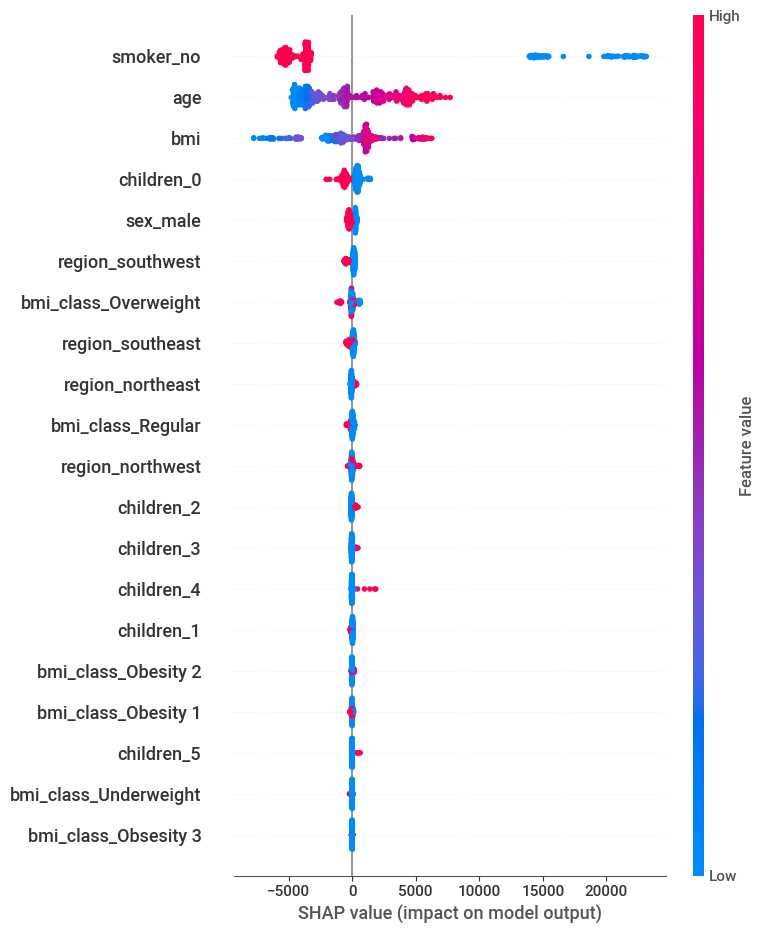

In [23]:
# Assessing feature importance
interpret_model(tuned_cat)

These bring to light what was expected: that both smoking status, BMI values and age were the most influential variables for our predictions. The discretisation of BMI values did not improve our model prediction substantially. This indicates that this strategy was not very useful in analysing this dataset. Let's now see our models predictions and finish the model for evaluation with the test data.

### Making predictions

In [24]:
# Predicting using the same data
predict_model(tuned_cat)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2620.2903,24304054.8788,4929.9143,0.8467,0.4352,0.2816


,age,bmi,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,smoker_no,...,region_southeast,region_southwest,bmi_class_Obesity 1,bmi_class_Obesity 2,bmi_class_Obsesity 3,bmi_class_Overweight,bmi_class_Regular,bmi_class_Underweight,charges,Label
0,-1.381411,0.369138,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1980.069946,3407.351147
1,-1.025011,2.367832,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42112.234375,39963.769123
2,1.541072,0.257568,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14119.620117,18155.221073
3,-0.169650,1.228226,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,40419.019531,41410.433075
4,1.113391,0.000161,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42303.691406,39483.591119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,0.828271,0.544462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9283.561523,11670.343885
358,0.614431,1.052902,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8978.185547,10490.491528
359,0.258030,-0.093080,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6849.025879,7590.262780
360,0.400591,-1.483718,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7222.786133,8170.205970


### Finalising the model

This will now join all our data (including train and test from the cross validation) and generate the model again using the defined parameters. This allows us to make use of all of the available data, except for the `test` data that we extract in the beginning of the project. After finalising the model, we will test how it predicts on itself (same set of data), beforing testing it in our `test` data.

In [25]:
# Finalising model
final_cat = finalize_model(tuned_cat)

# Predicting in the same data
predict_model(final_cat)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2308.1426,19108576.3409,4371.3358,0.8794,0.3798,0.2593


,age,bmi,sex_male,children_0,children_1,children_2,children_3,children_4,children_5,smoker_no,...,region_southeast,region_southwest,bmi_class_Obesity 1,bmi_class_Obesity 2,bmi_class_Obsesity 3,bmi_class_Overweight,bmi_class_Regular,bmi_class_Underweight,charges,Label
0,-1.381411,0.369138,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1980.069946,4248.779278
1,-1.025011,2.367832,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,42112.234375,40915.780703
2,1.541072,0.257568,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14119.620117,16146.195668
3,-0.169650,1.228226,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,40419.019531,42383.910304
4,1.113391,0.000161,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42303.691406,42007.266463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,0.828271,0.544462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9283.561523,11562.772106
358,0.614431,1.052902,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8978.185547,10661.176798
359,0.258030,-0.093080,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6849.025879,7586.587206
360,0.400591,-1.483718,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7222.786133,8307.040346


The output here is expected, yielding a higher R<sup>2</sup>, because this is the same data that we used to *build* the model. After this step, we will use it to predict the prices on our test data.

In [26]:
# Making new predictions
test_predictions = predict_model(final_cat, data=test_bmi)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2858.7488,25198624.8942,5019.8232,0.8279,0.4602,0.3203


In [27]:
test_predictions.head()

,age,sex,bmi,children,smoker,region,charges,bmi_class,Label
0,44,male,32.015,2,no,northwest,8116.26885,Obesity 1,9912.255294
1,24,female,26.600,0,no,northeast,3046.06200,Overweight,4540.009433
2,25,male,27.550,0,no,northwest,2523.16950,Overweight,3382.455649
3,24,male,29.830,0,yes,northeast,18648.42170,Overweight,22835.092665
4,43,male,27.800,0,yes,southwest,37829.72420,Overweight,25155.720020


Our R<sup>2</sup> value remained within expected range, indicating that our model did not overfit, which is good! After this step, we could save our model for future use. For simplicity, we will skip this step here.

Now, let's see how different our predictions were from our actual values:

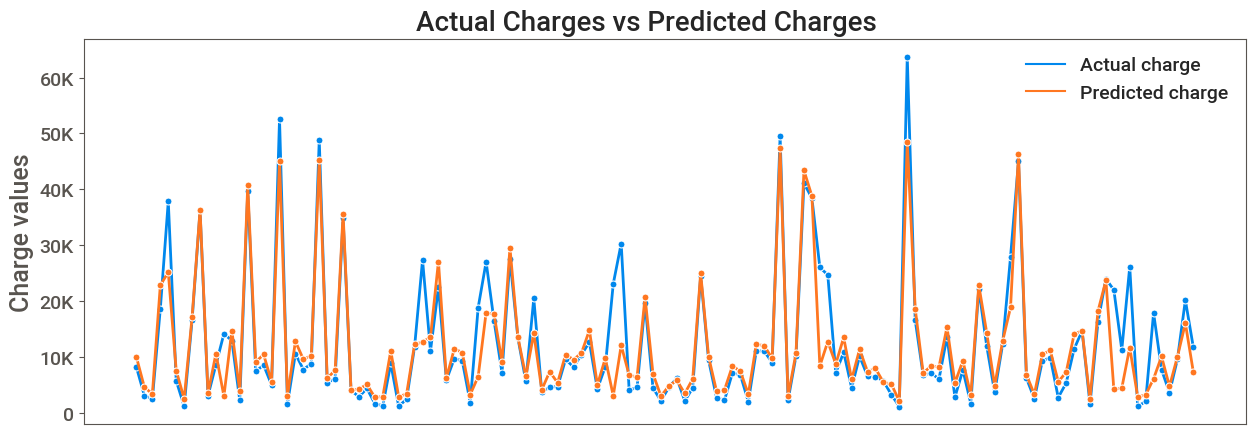

In [61]:
# Tidying data
pred_plot = test_predictions[['charges', 'Label']].copy()
pred_plot['Index'] = pred_plot.index
pred_plot.rename(columns=({'charges': 'Actual charge', 'Label': 'Predicted charge'}), inplace=True)
pred_plot = pred_plot.melt('Index', var_name='Charges', value_name='Value')

# Plotting
fig, ax = plt.subplots(figsize=(15,5))

fig.patch.set_alpha(0)

sns.lineplot(data=pred_plot, x='Index', y='Value', hue='Charges', marker='o', linewidth=2, ms=5, ax=ax);
ax.set_xlabel('')
ax.tick_params('both', labelsize=14)
ax.legend(fontsize=14)
ax.set_ylabel('Charge values', weight='bold', fontsize=18)
ax.yaxis.set_major_formatter(tools.reformat_large_tick_values)
ax.tick_params(bottom=False)
ax.set_xticklabels('')

fig.suptitle('Actual Charges vs Predicted Charges', fontsize=20, weight='bold', y=0.94);

We can see that our model did well, but it overall underpredicted the real charges. This indicates that our dataset could have more variables to improve it's predictive power, since only three of them were considered of high relevance to our model.

# Conclusion

In this notebook, we have employed the PyCaret framework for machine learning. The usage of this framework demonstrated a substantial decrease in time taken writing code, serving as a useful tool for preliminary analyses on data.

Our dataset did not have many important features for our model. The smoker status, age and BMI values were the most powerful variables for our predictions, and we were still able to reach ~0.82 R<sup>2</sup> score in our test data. This demonstrates the power of machine learning algorithms such as the CatBoost regressor. However, with more relevant features one might be able to achieve even better predictions in the future.

# References

1: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

2: https://en.wikipedia.org/wiki/Gradient_boosting

3: https://developer.nvidia.com/blog/catboost-fast-gradient-boosting-decision-trees/